In [0]:
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
from torchvision.utils import save_image 
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms.functional as TF
from collections import namedtuple
import os, os.path
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import zipfile
import glob

# CITYSCAPES DOWNLOAD

In [0]:
datadir = './cityscapes'
if not os.path.exists(datadir):
  #Login to cityscapes website
  !mkdir cityscapes && wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=waltermaffy&password=WallyffaM31&submit=Login' https://www.cityscapes-dataset.com/login/
  #Download dataset 11GB (left_image8bit_video) 20min
  !wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3
  with zipfile.ZipFile("leftImg8bit_trainvaltest.zip","r") as zip_ref:
      zip_ref.extractall("cityscapes")
  #Download dataset masks (240MB)
  !wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1
  with zipfile.ZipFile("gtFine_trainvaltest.zip","r") as zip_ref:
      zip_ref.extractall("cityscapes")
  !rm leftImg8bit_trainvaltest.zip gtFine_trainvaltest.zip index.html cookies.txt

In [0]:
class CityscapesDataset(Dataset):

    def __init__(self, root, split='train', mode='fine', augment=False):

        self.root = os.path.expanduser(root)
        self.mode = 'gtFine' if mode == 'fine' else 'gtCoarse'
        self.images_dir = os.path.join(self.root, 'leftImg8bit', split)
        self.targets_dir = os.path.join(self.root, self.mode, split)
        self.split = split
        self.augment = augment
        self.images = []
        self.targets = []
        self.mapping = {
            0: 0,  # unlabeled
            1: 0,  # ego vehicle
            2: 0,  # rect border
            3: 0,  # out of roi
            4: 0,  # static
            5: 0,  # dynamic
            6: 0,  # ground
            7: 1,  # road
            8: 0,  # sidewalk
            9: 0,  # parking
            10: 0,  # rail track
            11: 0,  # building
            12: 0,  # wall
            13: 0,  # fence
            14: 0,  # guard rail
            15: 0,  # bridge
            16: 0,  # tunnel
            17: 0,  # pole
            18: 0,  # polegroup
            19: 0,  # traffic light
            20: 0,  # traffic sign
            21: 0,  # vegetation
            22: 0,  # terrain
            23: 2,  # sky
            24: 0,  # person
            25: 0,  # rider
            26: 3,  # car
            27: 0,  # truck
            28: 0,  # bus
            29: 0,  # caravan
            30: 0,  # trailer
            31: 0,  # train
            32: 0,  # motorcycle
            33: 0,  # bicycle
            -1: 0  # licenseplate
        }
        self.mappingrgb = {
            0: (255, 0, 0),  # unlabeled
            1: (255, 0, 0),  # ego vehicle
            2: (255, 0, 0),  # rect border
            3: (255, 0, 0),  # out of roi
            4: (255, 0, 0),  # static
            5: (255, 0, 0),  # dynamic
            6: (255, 0, 0),  # ground
            7: (0, 255, 0),  # road
            8: (255, 0, 0),  # sidewalk
            9: (255, 0, 0),  # parking
            10: (255, 0, 0),  # rail track
            11: (255, 0, 0),  # building
            12: (255, 0, 0),  # wall
            13: (255, 0, 0),  # fence
            14: (255, 0, 0),  # guard rail
            15: (255, 0, 0),  # bridge
            16: (255, 0, 0),  # tunnel
            17: (255, 0, 0),  # pole
            18: (255, 0, 0),  # polegroup
            19: (255, 0, 0),  # traffic light
            20: (255, 0, 0),  # traffic sign
            21: (255, 0, 0),  # vegetation
            22: (255, 0, 0),  # terrain
            23: (0, 0, 255),  # sky
            24: (255, 0, 0),  # person
            25: (255, 0, 0),  # rider
            26: (255, 255, 0),  # car
            27: (255, 0, 0),  # truck
            28: (255, 0, 0),  # bus
            29: (255, 0, 0),  # caravan
            30: (255, 0, 0),  # trailer
            31: (255, 0, 0),  # train
            32: (255, 0, 0),  # motorcycle
            33: (255, 0, 0),  # bicycle
            -1: (255, 0, 0)  # licenseplate
        }

        # Ensure that this matches the above mapping!#!@#!@#
        # For example 4 classes, means we should map to the ids=(0,1,2,3)
        # This is used to specify how many outputs the network should product...
        self.num_classes = 4

        # =============================================
        # Check that inputs are valid
        # =============================================
        if mode not in ['fine', 'coarse']:
            raise ValueError('Invalid mode! Please use mode="fine" or mode="coarse"')
        if mode == 'fine' and split not in ['train', 'test', 'val']:
            raise ValueError('Invalid split for mode "fine"! Please use split="train", split="test" or split="val"')
        elif mode == 'coarse' and split not in ['train', 'train_extra', 'val']:
            raise ValueError('Invalid split for mode "coarse"! Please use split="train", split="train_extra" or split="val"')
        if not os.path.isdir(self.images_dir) or not os.path.isdir(self.targets_dir):
            raise RuntimeError('Dataset not found or incomplete. Please make sure all required folders for the'
                               ' specified "split" and "mode" are inside the "root" directory')

        # =============================================
        # Read in the paths to all images
        # =============================================
        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            target_dir = os.path.join(self.targets_dir, city)
            for file_name in os.listdir(img_dir):
                self.images.append(os.path.join(img_dir, file_name))
                target_name = '{}_{}'.format(file_name.split('_leftImg8bit')[0], '{}_labelIds.png'.format(self.mode))
                # target_name = '{}_{}'.format(file_name.split('_leftImg8bit')[0], '{}_color.png'.format(self.mode))
                self.targets.append(os.path.join(target_dir, target_name))

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of images: {}\n'.format(self.__len__())
        fmt_str += '    Split: {}\n'.format(self.split)
        fmt_str += '    Mode: {}\n'.format(self.mode)
        fmt_str += '    Augment: {}\n'.format(self.augment)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        return fmt_str

    def __len__(self):
        return len(self.images)

    def mask_to_class(self, mask):
        '''
        Given the cityscapes dataset, this maps to a 0..classes numbers.
        This is because we are using a subset of all masks, so we have this "mapping" function.
        This mapping function is used to map all the standard ids into the smaller subset.
        '''
        maskimg = torch.zeros((mask.size()[0], mask.size()[1]), dtype=torch.uint8)
        for k in self.mapping:
            maskimg[mask == k] = self.mapping[k]
        return maskimg

    def mask_to_rgb(self, mask):
        '''
        Given the Cityscapes mask file, this converts the ids into rgb colors.
        This is needed as we are interested in a sub-set of labels, thus can't just use the
        standard color output provided by the dataset.
        '''
        rgbimg = torch.zeros((3, mask.size()[0], mask.size()[1]), dtype=torch.uint8)
        for k in self.mappingrgb:
            rgbimg[0][mask == k] = self.mappingrgb[k][0]
            rgbimg[1][mask == k] = self.mappingrgb[k][1]
            rgbimg[2][mask == k] = self.mappingrgb[k][2]
        return rgbimg

    def class_to_rgb(self, mask):
        '''
        This function maps the classification index ids into the rgb.
        For example after the argmax from the network, you want to find what class
        a given pixel belongs too. This does that but just changes the color
        so that we can compare it directly to the rgb groundtruth label.
        '''
        mask2class = dict((v, k) for k, v in self.mapping.items())
        rgbimg = torch.zeros((3, mask.size()[0], mask.size()[1]), dtype=torch.uint8)
        for k in mask2class:
            rgbimg[0][mask == k] = self.mappingrgb[mask2class[k]][0]
            rgbimg[1][mask == k] = self.mappingrgb[mask2class[k]][1]
            rgbimg[2][mask == k] = self.mappingrgb[mask2class[k]][2]
        return rgbimg

    def __getitem__(self, index):

        # first load the RGB image
        image = Image.open(self.images[index]).convert('RGB')

        # next load the target
        target = Image.open(self.targets[index]).convert('L')

        # If augmenting, apply random transforms
        # Else we should just resize the image down to the correct size
        if self.augment:
            # Resize
            image = TF.resize(image, size=(128+10, 256+10), interpolation=Image.BILINEAR)
            target = TF.resize(target, size=(128+10, 256+10), interpolation=Image.NEAREST)
            # Random crop
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(128, 256))
            image = TF.crop(image, i, j, h, w)
            target = TF.crop(target, i, j, h, w)
            # Random horizontal flipping
            if random.random() > 0.5:
                image = TF.hflip(image)
                target = TF.hflip(target)
            # Random vertical flipping
            # (I found this caused issues with the sky=road during prediction)
            # if random.random() > 0.5:
            #    image = TF.vflip(image)
            #    target = TF.vflip(target)
        else:
            # Resize
            image = TF.resize(image, size=(128, 256), interpolation=Image.BILINEAR)
            target = TF.resize(target, size=(128, 256), interpolation=Image.NEAREST)

        # convert to pytorch tensors
        # target = TF.to_tensor(target)
        target = torch.from_numpy(np.array(target, dtype=np.uint8))
        image = TF.to_tensor(image)

        # convert the labels into a mask
        targetrgb = self.mask_to_rgb(target)
        targetmask = self.mask_to_class(target)
        targetmask = targetmask.long()
        targetrgb = targetrgb.long()

        # finally return the image pair
        return image, targetmask, targetrgb

## CITYSCAPES PREPROCESSING FOR IMG_TO_IMG

In [0]:
def load_resized_img(path):
    return Image.open(path).convert('RGB').resize((256, 256))

def check_matching_pair(segmap_path, photo_path):
    segmap_identifier = os.path.basename(segmap_path).replace('_gtFine_color', '')
    photo_identifier = os.path.basename(photo_path).replace('_leftImg8bit', '')
        
    assert segmap_identifier == photo_identifier, \
        "[%s] and [%s] don't seem to be matching. Aborting." % (segmap_path, photo_path)
    
def process_cityscapes(gtFine_dir, leftImg8bit_dir, output_dir, phase):
    save_phase = 'test' if phase == 'val' else 'train'
    savedir = os.path.join(output_dir, save_phase)
    os.makedirs(savedir, exist_ok=True)
    os.makedirs(savedir + 'A', exist_ok=True)
    os.makedirs(savedir + 'B', exist_ok=True)
    print("Directory structure prepared at %s" % output_dir)
    
    segmap_expr = os.path.join(gtFine_dir, phase) + "/*/*_color.png"
    segmap_paths = glob.glob(segmap_expr)
    segmap_paths = sorted(segmap_paths)

    photo_expr = os.path.join(leftImg8bit_dir, phase) + "/*/*_leftImg8bit.png"
    photo_paths = glob.glob(photo_expr)
    photo_paths = sorted(photo_paths)

    assert len(segmap_paths) == len(photo_paths), \
        "%d images that match [%s], and %d images that match [%s]. Aborting." % (len(segmap_paths), segmap_expr, len(photo_paths), photo_expr)

    for i, (segmap_path, photo_path) in enumerate(zip(segmap_paths, photo_paths)):
        check_matching_pair(segmap_path, photo_path)
        segmap = load_resized_img(segmap_path)
        photo = load_resized_img(photo_path)

        # data for pix2pix where the two images are placed side-by-side
        sidebyside = Image.new('RGB', (512, 256))
        sidebyside.paste(segmap, (256, 0))
        sidebyside.paste(photo, (0, 0))
        savepath = os.path.join(savedir, "%d.jpg" % i)
        sidebyside.save(savepath, format='JPEG', subsampling=0, quality=100)

        # data for cyclegan where the two images are stored at two distinct directories
        savepath = os.path.join(savedir + 'A', "%d_A.jpg" % i)
        photo.save(savepath, format='JPEG', subsampling=0, quality=100)
        savepath = os.path.join(savedir + 'B', "%d_B.jpg" % i)
        segmap.save(savepath, format='JPEG', subsampling=0, quality=100)
        
        if i % (len(segmap_paths) // 10) == 0:
            print("%d / %d: last image saved at %s, " % (i, len(segmap_paths), savepath))

#print('Preparing Cityscapes Dataset for train phase')
#process_cityscapes('cityscapes/gtFine', 'cityscapes/leftImg8bit', './datasets/cityscapes/', "train")
#print('Done')

# CUSTOM LAYERS

In [0]:
def conv_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def conv_trans_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool

def conv_block_2(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

def conv_block_3(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        conv_block(out_dim, out_dim, act_fn),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

 
def plot_result(image, ground_th, predicted):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,10))
  ax1.imshow(image[0].permute(1, 2, 0))
  ax2.imshow(ground_th[0].permute(1, 2, 0))
  ax3.imshow(predicted[0].permute(1, 2, 0).numpy().astype(np.uint8))
  ax1.set_title('Original image')
  ax1.axis('off')
  ax2.set_title('Ground truth')
  ax2.axis('off')
  ax3.set_title('Predicted image')
  ax3.axis('off')
  plt.show()

  

# U-NET
<img src="https://miro.medium.com/max/1553/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="600">

In [0]:
class UnetGenerator(nn.Module):

    def __init__(self, in_dim, out_dim, num_filter):
        super(UnetGenerator, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        self.down_1 = conv_block_2(self.in_dim, self.num_filter, act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1, self.num_filter*2, act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2, self.num_filter*4, act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4, self.num_filter*8, act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8, self.num_filter*16, act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16, self.num_filter*8, act_fn)
        self.up_1 = conv_block_2(self.num_filter*16, self.num_filter*8, act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8, self.num_filter*4, act_fn)
        self.up_2 = conv_block_2(self.num_filter*8, self.num_filter*4, act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4, self.num_filter*2, act_fn)
        self.up_3 = conv_block_2(self.num_filter*4, self.num_filter*2, act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2, self.num_filter*1, act_fn)
        self.up_4 = conv_block_2(self.num_filter*2, self.num_filter*1, act_fn)

        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter, self.out_dim, 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1, down_4], dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2, down_3], dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3, down_2], dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4, down_1], dim=1)
        up_4 = self.up_4(concat_4)

        out = self.out(up_4)

        return out

# MAIN

Dataset CityscapesDataset
    Number of images: 2975
    Split: train
    Mode: gtFine
    Augment: True
    Root Location: ./cityscapes

creating unet model...
Epoch[0/100][ 0/2975]	 | 	Loss: 1.49
Epoch[0/100][400/2975]	 | 	Loss: 0.64
Epoch[0/100][800/2975]	 | 	Loss: 0.57
Epoch[0/100][1200/2975]	 | 	Loss: 0.65
Epoch[0/100][1600/2975]	 | 	Loss: 0.77
Epoch[0/100][2000/2975]	 | 	Loss: 0.53
Epoch[0/100][2400/2975]	 | 	Loss: 0.69
Epoch[0/100][2800/2975]	 | 	Loss: 0.52


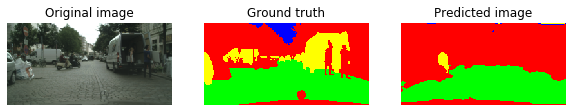

Epoch[1/100][ 0/2975]	 | 	Loss: 0.47
Epoch[1/100][400/2975]	 | 	Loss: 0.59
Epoch[1/100][800/2975]	 | 	Loss: 0.52
Epoch[1/100][1200/2975]	 | 	Loss: 0.48
Epoch[1/100][1600/2975]	 | 	Loss: 0.48
Epoch[1/100][2000/2975]	 | 	Loss: 0.44
Epoch[1/100][2400/2975]	 | 	Loss: 0.47
Epoch[1/100][2800/2975]	 | 	Loss: 0.44


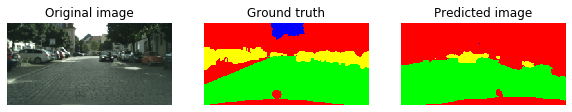

Epoch[2/100][ 0/2975]	 | 	Loss: 0.41
Epoch[2/100][400/2975]	 | 	Loss: 0.44
Epoch[2/100][800/2975]	 | 	Loss: 0.44
Epoch[2/100][1200/2975]	 | 	Loss: 0.37
Epoch[2/100][1600/2975]	 | 	Loss: 0.42
Epoch[2/100][2000/2975]	 | 	Loss: 0.41
Epoch[2/100][2400/2975]	 | 	Loss: 0.42
Epoch[2/100][2800/2975]	 | 	Loss: 0.42


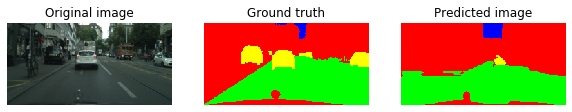

Epoch[3/100][ 0/2975]	 | 	Loss: 0.44
Epoch[3/100][400/2975]	 | 	Loss: 0.44
Epoch[3/100][800/2975]	 | 	Loss: 0.42
Epoch[3/100][1200/2975]	 | 	Loss: 0.47
Epoch[3/100][1600/2975]	 | 	Loss: 0.46
Epoch[3/100][2000/2975]	 | 	Loss: 0.83
Epoch[3/100][2400/2975]	 | 	Loss: 0.42
Epoch[3/100][2800/2975]	 | 	Loss: 0.47


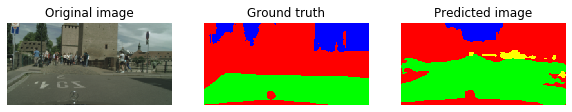

Epoch[4/100][ 0/2975]	 | 	Loss: 0.41
Epoch[4/100][400/2975]	 | 	Loss: 0.40
Epoch[4/100][800/2975]	 | 	Loss: 0.48
Epoch[4/100][1200/2975]	 | 	Loss: 0.45
Epoch[4/100][1600/2975]	 | 	Loss: 0.39
Epoch[4/100][2000/2975]	 | 	Loss: 0.40
Epoch[4/100][2400/2975]	 | 	Loss: 0.43
Epoch[4/100][2800/2975]	 | 	Loss: 0.50


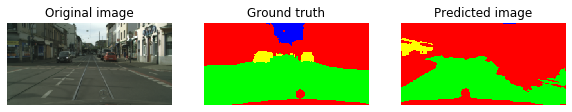

Epoch[5/100][ 0/2975]	 | 	Loss: 0.40
Epoch[5/100][400/2975]	 | 	Loss: 0.42
Epoch[5/100][800/2975]	 | 	Loss: 0.45
Epoch[5/100][1200/2975]	 | 	Loss: 0.43
Epoch[5/100][1600/2975]	 | 	Loss: 0.41
Epoch[5/100][2000/2975]	 | 	Loss: 0.60
Epoch[5/100][2400/2975]	 | 	Loss: 0.41
Epoch[5/100][2800/2975]	 | 	Loss: 0.62


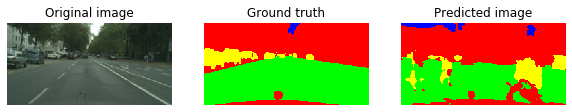

Epoch[6/100][ 0/2975]	 | 	Loss: 0.80
Epoch[6/100][400/2975]	 | 	Loss: 0.49
Epoch[6/100][800/2975]	 | 	Loss: 0.55
Epoch[6/100][1200/2975]	 | 	Loss: 0.44
Epoch[6/100][1600/2975]	 | 	Loss: 0.41
Epoch[6/100][2000/2975]	 | 	Loss: 0.44
Epoch[6/100][2400/2975]	 | 	Loss: 0.40
Epoch[6/100][2800/2975]	 | 	Loss: 0.43


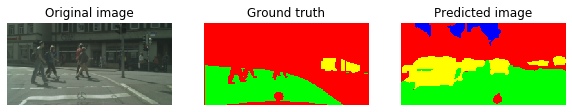

Epoch[7/100][ 0/2975]	 | 	Loss: 0.42
Epoch[7/100][400/2975]	 | 	Loss: 0.42
Epoch[7/100][800/2975]	 | 	Loss: 0.53
Epoch[7/100][1200/2975]	 | 	Loss: 0.41
Epoch[7/100][1600/2975]	 | 	Loss: 0.90
Epoch[7/100][2000/2975]	 | 	Loss: 0.46
Epoch[7/100][2400/2975]	 | 	Loss: 0.39
Epoch[7/100][2800/2975]	 | 	Loss: 0.39


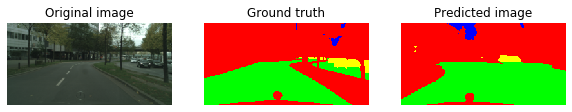

Epoch[8/100][ 0/2975]	 | 	Loss: 0.37
Epoch[8/100][400/2975]	 | 	Loss: 0.36
Epoch[8/100][800/2975]	 | 	Loss: 0.46
Epoch[8/100][1200/2975]	 | 	Loss: 0.40
Epoch[8/100][1600/2975]	 | 	Loss: 0.42
Epoch[8/100][2000/2975]	 | 	Loss: 0.43
Epoch[8/100][2400/2975]	 | 	Loss: 0.38
Epoch[8/100][2800/2975]	 | 	Loss: 0.41


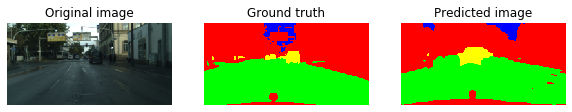

Epoch[9/100][ 0/2975]	 | 	Loss: 0.44
Epoch[9/100][400/2975]	 | 	Loss: 0.39
Epoch[9/100][800/2975]	 | 	Loss: 0.39
Epoch[9/100][1200/2975]	 | 	Loss: 0.41
Epoch[9/100][1600/2975]	 | 	Loss: 0.41
Epoch[9/100][2000/2975]	 | 	Loss: 0.50
Epoch[9/100][2400/2975]	 | 	Loss: 0.41
Epoch[9/100][2800/2975]	 | 	Loss: 0.38


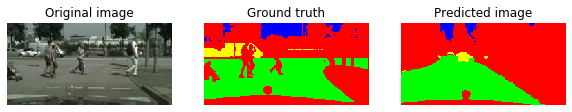

Epoch[10/100][ 0/2975]	 | 	Loss: 0.40
Epoch[10/100][400/2975]	 | 	Loss: 0.40
Epoch[10/100][800/2975]	 | 	Loss: 0.37
Epoch[10/100][1200/2975]	 | 	Loss: 0.39
Epoch[10/100][1600/2975]	 | 	Loss: 0.39
Epoch[10/100][2000/2975]	 | 	Loss: 0.46
Epoch[10/100][2400/2975]	 | 	Loss: 0.37
Epoch[10/100][2800/2975]	 | 	Loss: 0.41


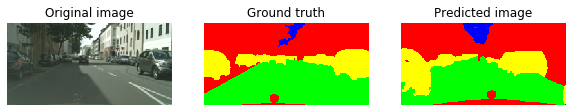

Epoch[11/100][ 0/2975]	 | 	Loss: 0.43
Epoch[11/100][400/2975]	 | 	Loss: 0.41
Epoch[11/100][800/2975]	 | 	Loss: 0.40
Epoch[11/100][1200/2975]	 | 	Loss: 0.41
Epoch[11/100][1600/2975]	 | 	Loss: 0.39
Epoch[11/100][2000/2975]	 | 	Loss: 0.39
Epoch[11/100][2400/2975]	 | 	Loss: 0.41
Epoch[11/100][2800/2975]	 | 	Loss: 0.39


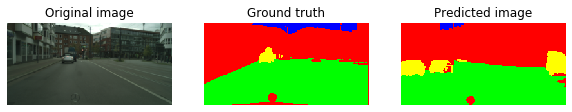

Epoch[12/100][ 0/2975]	 | 	Loss: 0.40
Epoch[12/100][400/2975]	 | 	Loss: 0.44
Epoch[12/100][800/2975]	 | 	Loss: 0.49
Epoch[12/100][1200/2975]	 | 	Loss: 0.38
Epoch[12/100][1600/2975]	 | 	Loss: 0.43
Epoch[12/100][2000/2975]	 | 	Loss: 0.38
Epoch[12/100][2400/2975]	 | 	Loss: 0.54
Epoch[12/100][2800/2975]	 | 	Loss: 0.41


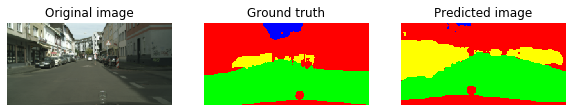

Epoch[13/100][ 0/2975]	 | 	Loss: 0.42
Epoch[13/100][400/2975]	 | 	Loss: 0.40
Epoch[13/100][800/2975]	 | 	Loss: 0.42
Epoch[13/100][1200/2975]	 | 	Loss: 0.46
Epoch[13/100][1600/2975]	 | 	Loss: 0.41
Epoch[13/100][2000/2975]	 | 	Loss: 0.40
Epoch[13/100][2400/2975]	 | 	Loss: 0.38
Epoch[13/100][2800/2975]	 | 	Loss: 0.40


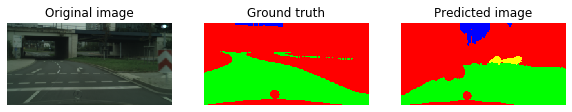

Epoch[14/100][ 0/2975]	 | 	Loss: 0.39
Epoch[14/100][400/2975]	 | 	Loss: 0.38
Epoch[14/100][800/2975]	 | 	Loss: 0.41
Epoch[14/100][1200/2975]	 | 	Loss: 0.38
Epoch[14/100][1600/2975]	 | 	Loss: 0.38
Epoch[14/100][2000/2975]	 | 	Loss: 0.40
Epoch[14/100][2400/2975]	 | 	Loss: 0.37
Epoch[14/100][2800/2975]	 | 	Loss: 0.38


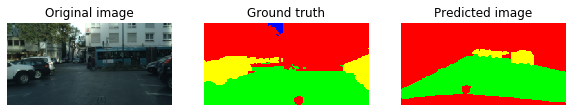

Epoch[15/100][ 0/2975]	 | 	Loss: 0.42
Epoch[15/100][400/2975]	 | 	Loss: 0.45
Epoch[15/100][800/2975]	 | 	Loss: 0.37
Epoch[15/100][1200/2975]	 | 	Loss: 0.37
Epoch[15/100][1600/2975]	 | 	Loss: 0.45
Epoch[15/100][2000/2975]	 | 	Loss: 1.04
Epoch[15/100][2400/2975]	 | 	Loss: 0.40
Epoch[15/100][2800/2975]	 | 	Loss: 0.41


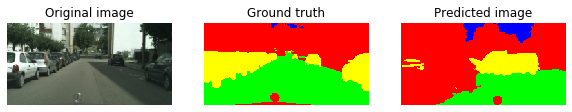

Epoch[16/100][ 0/2975]	 | 	Loss: 0.59
Epoch[16/100][400/2975]	 | 	Loss: 0.38
Epoch[16/100][800/2975]	 | 	Loss: 0.50
Epoch[16/100][1200/2975]	 | 	Loss: 0.39
Epoch[16/100][1600/2975]	 | 	Loss: 0.39
Epoch[16/100][2000/2975]	 | 	Loss: 0.43
Epoch[16/100][2400/2975]	 | 	Loss: 0.37
Epoch[16/100][2800/2975]	 | 	Loss: 0.36


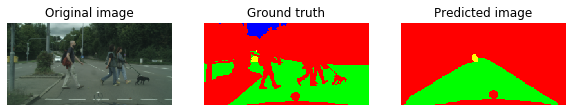

Epoch[17/100][ 0/2975]	 | 	Loss: 0.41
Epoch[17/100][400/2975]	 | 	Loss: 0.37
Epoch[17/100][800/2975]	 | 	Loss: 0.38
Epoch[17/100][1200/2975]	 | 	Loss: 0.40
Epoch[17/100][1600/2975]	 | 	Loss: 0.44
Epoch[17/100][2000/2975]	 | 	Loss: 0.37
Epoch[17/100][2400/2975]	 | 	Loss: 0.38
Epoch[17/100][2800/2975]	 | 	Loss: 0.42


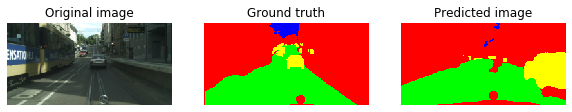

Epoch[18/100][ 0/2975]	 | 	Loss: 0.38
Epoch[18/100][400/2975]	 | 	Loss: 0.41
Epoch[18/100][800/2975]	 | 	Loss: 0.38
Epoch[18/100][1200/2975]	 | 	Loss: 0.40
Epoch[18/100][1600/2975]	 | 	Loss: 0.38
Epoch[18/100][2000/2975]	 | 	Loss: 0.38
Epoch[18/100][2400/2975]	 | 	Loss: 0.39
Epoch[18/100][2800/2975]	 | 	Loss: 0.39


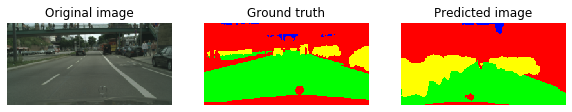

Epoch[19/100][ 0/2975]	 | 	Loss: 0.45
Epoch[19/100][400/2975]	 | 	Loss: 0.52
Epoch[19/100][800/2975]	 | 	Loss: 0.38
Epoch[19/100][1200/2975]	 | 	Loss: 0.41
Epoch[19/100][1600/2975]	 | 	Loss: 0.40
Epoch[19/100][2000/2975]	 | 	Loss: 0.59
Epoch[19/100][2400/2975]	 | 	Loss: 0.39
Epoch[19/100][2800/2975]	 | 	Loss: 0.40


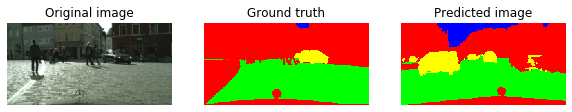

Epoch[20/100][ 0/2975]	 | 	Loss: 0.38
Epoch[20/100][400/2975]	 | 	Loss: 0.39
Epoch[20/100][800/2975]	 | 	Loss: 0.38
Epoch[20/100][1200/2975]	 | 	Loss: 0.43
Epoch[20/100][1600/2975]	 | 	Loss: 0.36
Epoch[20/100][2000/2975]	 | 	Loss: 0.38
Epoch[20/100][2400/2975]	 | 	Loss: 0.38
Epoch[20/100][2800/2975]	 | 	Loss: 0.38


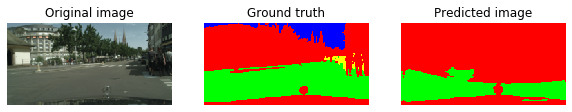

Epoch[21/100][ 0/2975]	 | 	Loss: 0.41
Epoch[21/100][400/2975]	 | 	Loss: 0.36
Epoch[21/100][800/2975]	 | 	Loss: 0.40
Epoch[21/100][1200/2975]	 | 	Loss: 0.44
Epoch[21/100][1600/2975]	 | 	Loss: 0.38
Epoch[21/100][2000/2975]	 | 	Loss: 0.38
Epoch[21/100][2400/2975]	 | 	Loss: 0.52
Epoch[21/100][2800/2975]	 | 	Loss: 0.40


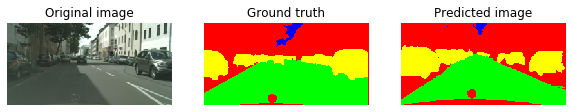

Epoch[22/100][ 0/2975]	 | 	Loss: 0.45
Epoch[22/100][400/2975]	 | 	Loss: 0.38
Epoch[22/100][800/2975]	 | 	Loss: 0.37
Epoch[22/100][1200/2975]	 | 	Loss: 0.45
Epoch[22/100][1600/2975]	 | 	Loss: 0.38
Epoch[22/100][2000/2975]	 | 	Loss: 0.42
Epoch[22/100][2400/2975]	 | 	Loss: 0.45
Epoch[22/100][2800/2975]	 | 	Loss: 0.40


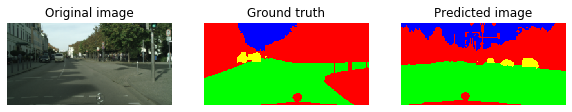

Epoch[23/100][ 0/2975]	 | 	Loss: 0.39
Epoch[23/100][400/2975]	 | 	Loss: 0.39
Epoch[23/100][800/2975]	 | 	Loss: 0.42
Epoch[23/100][1200/2975]	 | 	Loss: 0.44
Epoch[23/100][1600/2975]	 | 	Loss: 0.38
Epoch[23/100][2000/2975]	 | 	Loss: 0.42
Epoch[23/100][2400/2975]	 | 	Loss: 0.39
Epoch[23/100][2800/2975]	 | 	Loss: 0.40


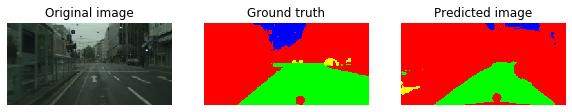

Epoch[24/100][ 0/2975]	 | 	Loss: 0.39
Epoch[24/100][400/2975]	 | 	Loss: 0.37
Epoch[24/100][800/2975]	 | 	Loss: 0.38
Epoch[24/100][1200/2975]	 | 	Loss: 0.37
Epoch[24/100][1600/2975]	 | 	Loss: 0.38
Epoch[24/100][2000/2975]	 | 	Loss: 0.42
Epoch[24/100][2400/2975]	 | 	Loss: 0.42
Epoch[24/100][2800/2975]	 | 	Loss: 0.39


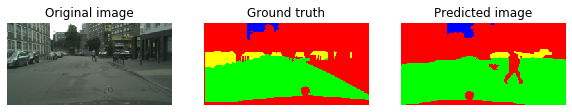

Epoch[25/100][ 0/2975]	 | 	Loss: 0.39
Epoch[25/100][400/2975]	 | 	Loss: 0.43
Epoch[25/100][800/2975]	 | 	Loss: 0.46
Epoch[25/100][1200/2975]	 | 	Loss: 0.41
Epoch[25/100][1600/2975]	 | 	Loss: 0.41
Epoch[25/100][2000/2975]	 | 	Loss: 0.43
Epoch[25/100][2400/2975]	 | 	Loss: 0.44
Epoch[25/100][2800/2975]	 | 	Loss: 0.37


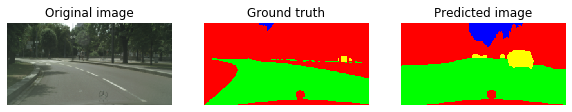

Epoch[26/100][ 0/2975]	 | 	Loss: 0.35
Epoch[26/100][400/2975]	 | 	Loss: 0.37
Epoch[26/100][800/2975]	 | 	Loss: 0.37
Epoch[26/100][1200/2975]	 | 	Loss: 0.45
Epoch[26/100][1600/2975]	 | 	Loss: 0.37
Epoch[26/100][2000/2975]	 | 	Loss: 0.45
Epoch[26/100][2400/2975]	 | 	Loss: 0.37
Epoch[26/100][2800/2975]	 | 	Loss: 0.37


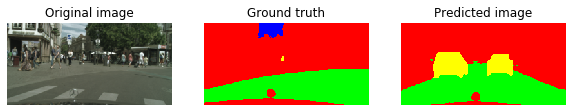

Epoch[27/100][ 0/2975]	 | 	Loss: 0.36
Epoch[27/100][400/2975]	 | 	Loss: 0.39
Epoch[27/100][800/2975]	 | 	Loss: 0.37
Epoch[27/100][1200/2975]	 | 	Loss: 0.37
Epoch[27/100][1600/2975]	 | 	Loss: 0.38
Epoch[27/100][2000/2975]	 | 	Loss: 0.39


In [0]:
#PARAMETERS
datadir = './cityscapes'
batch_size = 1
num_gpu = 1
losstype = 'segment'
checkpoint_file = './unet_checkpoint.pt'
#hyper-params
lr = 0.0002
epochs = 100

device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpu > 0) else "cpu")

# cityscapes dataset loading
img_data = CityscapesDataset(datadir, split='train', mode='fine', augment=True)
#img_data = dset.Cityscapes(datadir, split='train', mode='fine', target_type=['semantic', 'color'])
dataloader = DataLoader(img_data, batch_size=batch_size, shuffle=True, num_workers=4)
print(img_data)

loss = nn.CrossEntropyLoss() #semantic
num_classes = img_data.num_classes  # background, road, sky, car

# initiate generator and optimizer
print("creating unet model...")
generator = UnetGenerator(3, num_classes, 64).to(device)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

# load pretrained model if it is there
if os.path.isfile(checkpoint_file):
    generator = torch.load(checkpoint_file)
    print("    - model restored from file....")
    print("    - filename = %s" % checkpoint_file)

# or log file that has the output of our loss
file_loss = open('./unet_loss', 'w')

# make the result directory
if not os.path.exists('./result/'):
    os.makedirs('./result/')

#the training loop!
for epoch in range(epochs):
    for idx_batch, (imagergb, labelmask, labelrgb) in enumerate(dataloader):

        # zero the grad of the network before feed-forward
        gen_optimizer.zero_grad()

        # send to the GPU and do a forward pass
        x = imagergb.to(device)
        y_ = labelmask.to(device)
        y = generator(x)
        
        #calculate the loss and back propagate
        g_loss = loss(y, y_)
        g_loss.backward()
        gen_optimizer.step()

        # every 400 images, save the current image and also checkpoint the model to disk
        if idx_batch % 400 == 0:

            print("Epoch[%d/%3d][%2d/%d]\t | \tLoss: %.2f" % (epoch, epochs, idx_batch, len(dataloader), g_loss.item()))
            # save the original image and label batches to file
            save_image(x.cpu().data, "./result/original_image_{}_{}.png".format(epoch, idx_batch))
            #save_image(labelrgb, "./result/label_image_{}_{}.png".format(epoch, idx_batch))

            # max over the classes should be the prediction our prediction is [N, classes, W, H]
            # so we max over the second dimension and take the max response if we are doing rgb reconstruction, then just directly save it to file
            y_threshed = torch.zeros((y.size()[0], 3, y.size()[2], y.size()[3]))
            for idx in range(0, y.size()[0]):
                maxindex = torch.argmax(y[idx], dim=0).cpu().int()
                y_threshed[idx] = img_data.class_to_rgb(maxindex)
            save_image(y_threshed, "./result/gen_image_{}_{}.png".format(epoch, idx_batch))
        
            #torch.save(generator, checkpoint_file)

    plot_result(imagergb,labelrgb,y_threshed)

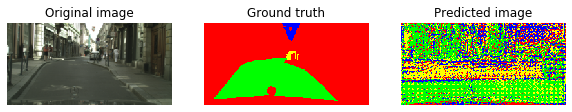

In [0]:
plot_result(imagergb,labelrgb,y_threshed)